### Empirical mode decomposition of the signal

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/vanderbilt")

In [2]:
import os
from functools import partial

import emd
import matplotlib.pyplot as plt
import numpy as np
import PyEMD
import skimage as ski
import umap
import xarray as xr
from frites.utils import parallel_func
from mne.time_frequency import psd_array_multitaper, psd_array_welch
from scipy.optimize import curve_fit
from skimage.segmentation import watershed
from tqdm import tqdm

from VUDA.emd import emd_vec
from VUDA.io.loadbinary import LoadBinary

/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distanc

#### Load data

In [3]:
date = "10-20-2022"
monkey = "FN"
channel = 21

In [4]:
filepath = os.path.expanduser(f"~/funcog/HoffmanData/{monkey}/{date}/aHPC_B_cnct.nc")

In [5]:
data = xr.load_dataarray(filepath)

In [6]:
# Get zero timestamp
t_init = data.times.data[0]
# Get final timestamp
t_end = data.times.data[0]
# End of treehouse
t_th_end = float(data.attrs["TH_end"].split(", ")[1])
# Beggining of sleep
t_sleep_init = float(data.attrs["Sleep_start"].split(", ")[1])

In [7]:
data = data.sel(times=slice(t_init, t_th_end))

In [8]:
times = data.times.values

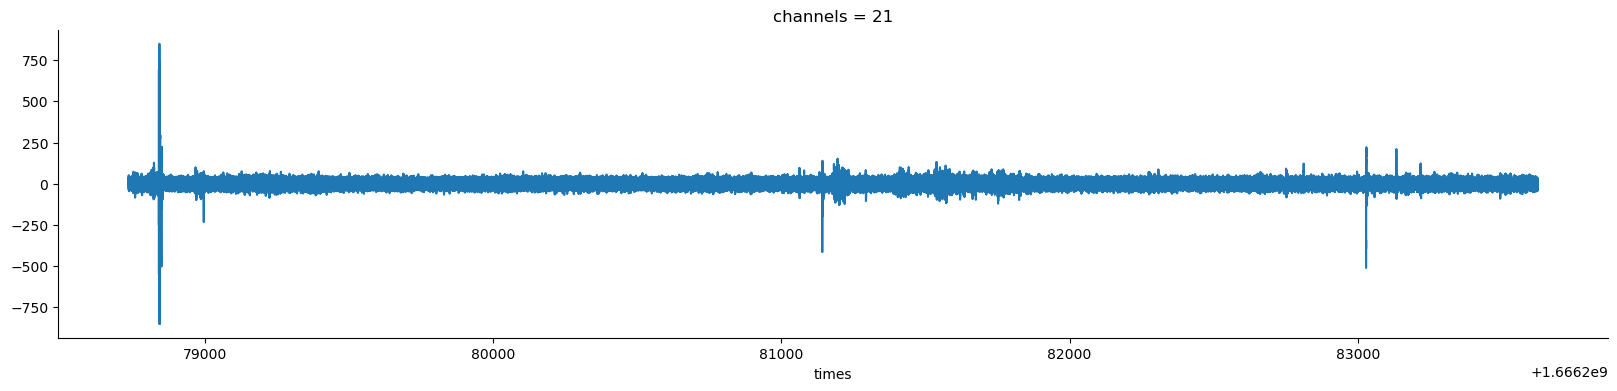

In [9]:
plt.figure(figsize=(20, 4))
ax = plt.subplot(111)
data.sel(channels=channel).plot()
[ax.spines[key].set_visible(False) for key in ["top", "right"]];

#### Extract IMFs

In [10]:
def standardize_imf_per_block(IMFs):
    """
    Standardizes the number of intrinsic mode functions (IMFs) per block in an xarray Dataset.
    It sums slower IMFs in case a given block has more IMFs, thant the block that has the least
    number of IMFs.

    Parameters:
    - IMFs (xarray.Dataset): Input Dataset containing IMFs with dimensions ('blocks', 'IMFs', ...).

    Returns:
    - xarray.Dataset: Output Dataset with standardized IMFs per block.

    The function standardizes the number of IMFs per block by either summing the first
    (10 - n_imfs_min + 1) IMFs or keeping the original IMFs if the number is already less
    than or equal to n_imfs_min.

    Note:
    - The function assumes that the input Dataset has dimensions ('blocks', 'IMFs', ...).
    - The result is a new Dataset with standardized IMFs per block.
    """

    assert isinstance(IMFs, xr.DataArray)
    np.testing.assert_array_equal(IMFs.dims, ("blocks", "IMFs", "times"))

    n_imfs_min = IMFs.n_imfs_per_block.min()
    attrs = IMFs.attrs

    reduced = []

    for i in range(IMFs.sizes["blocks"]):

        temp = IMFs[i].dropna("IMFs").drop_vars("IMFs")
        n_imfs = temp.shape[0]

        if n_imfs > n_imfs_min:

            reduced += [
                xr.concat(
                    (
                        temp[0 : n_imfs - n_imfs_min + 1].sum("IMFs", keepdims=True),
                        temp[n_imfs - n_imfs_min + 1 :],
                    ),
                    "IMFs",
                )
            ]

        else:
            reduced += [temp]

    IMFs = xr.concat(reduced, "blocks")
    IMFs.attrs = attrs

    return IMFs

In [11]:
IMFs_single = emd_vec(
    data.sel(channels=channel).values,
    times,
    method="eemd",
    max_imfs=None,
    block_size=200,
    nensembles=5,
    use_min_block_size=True,
    remove_fastest_imf=True,
    n_jobs=20,
    imf_opts={"stop_method": "fixed", "max_iters": 5},
)

  0%|          |  : 0/200 [00:00<?,       ?it/s]

In [12]:
IMFs_single = standardize_imf_per_block(IMFs_single)

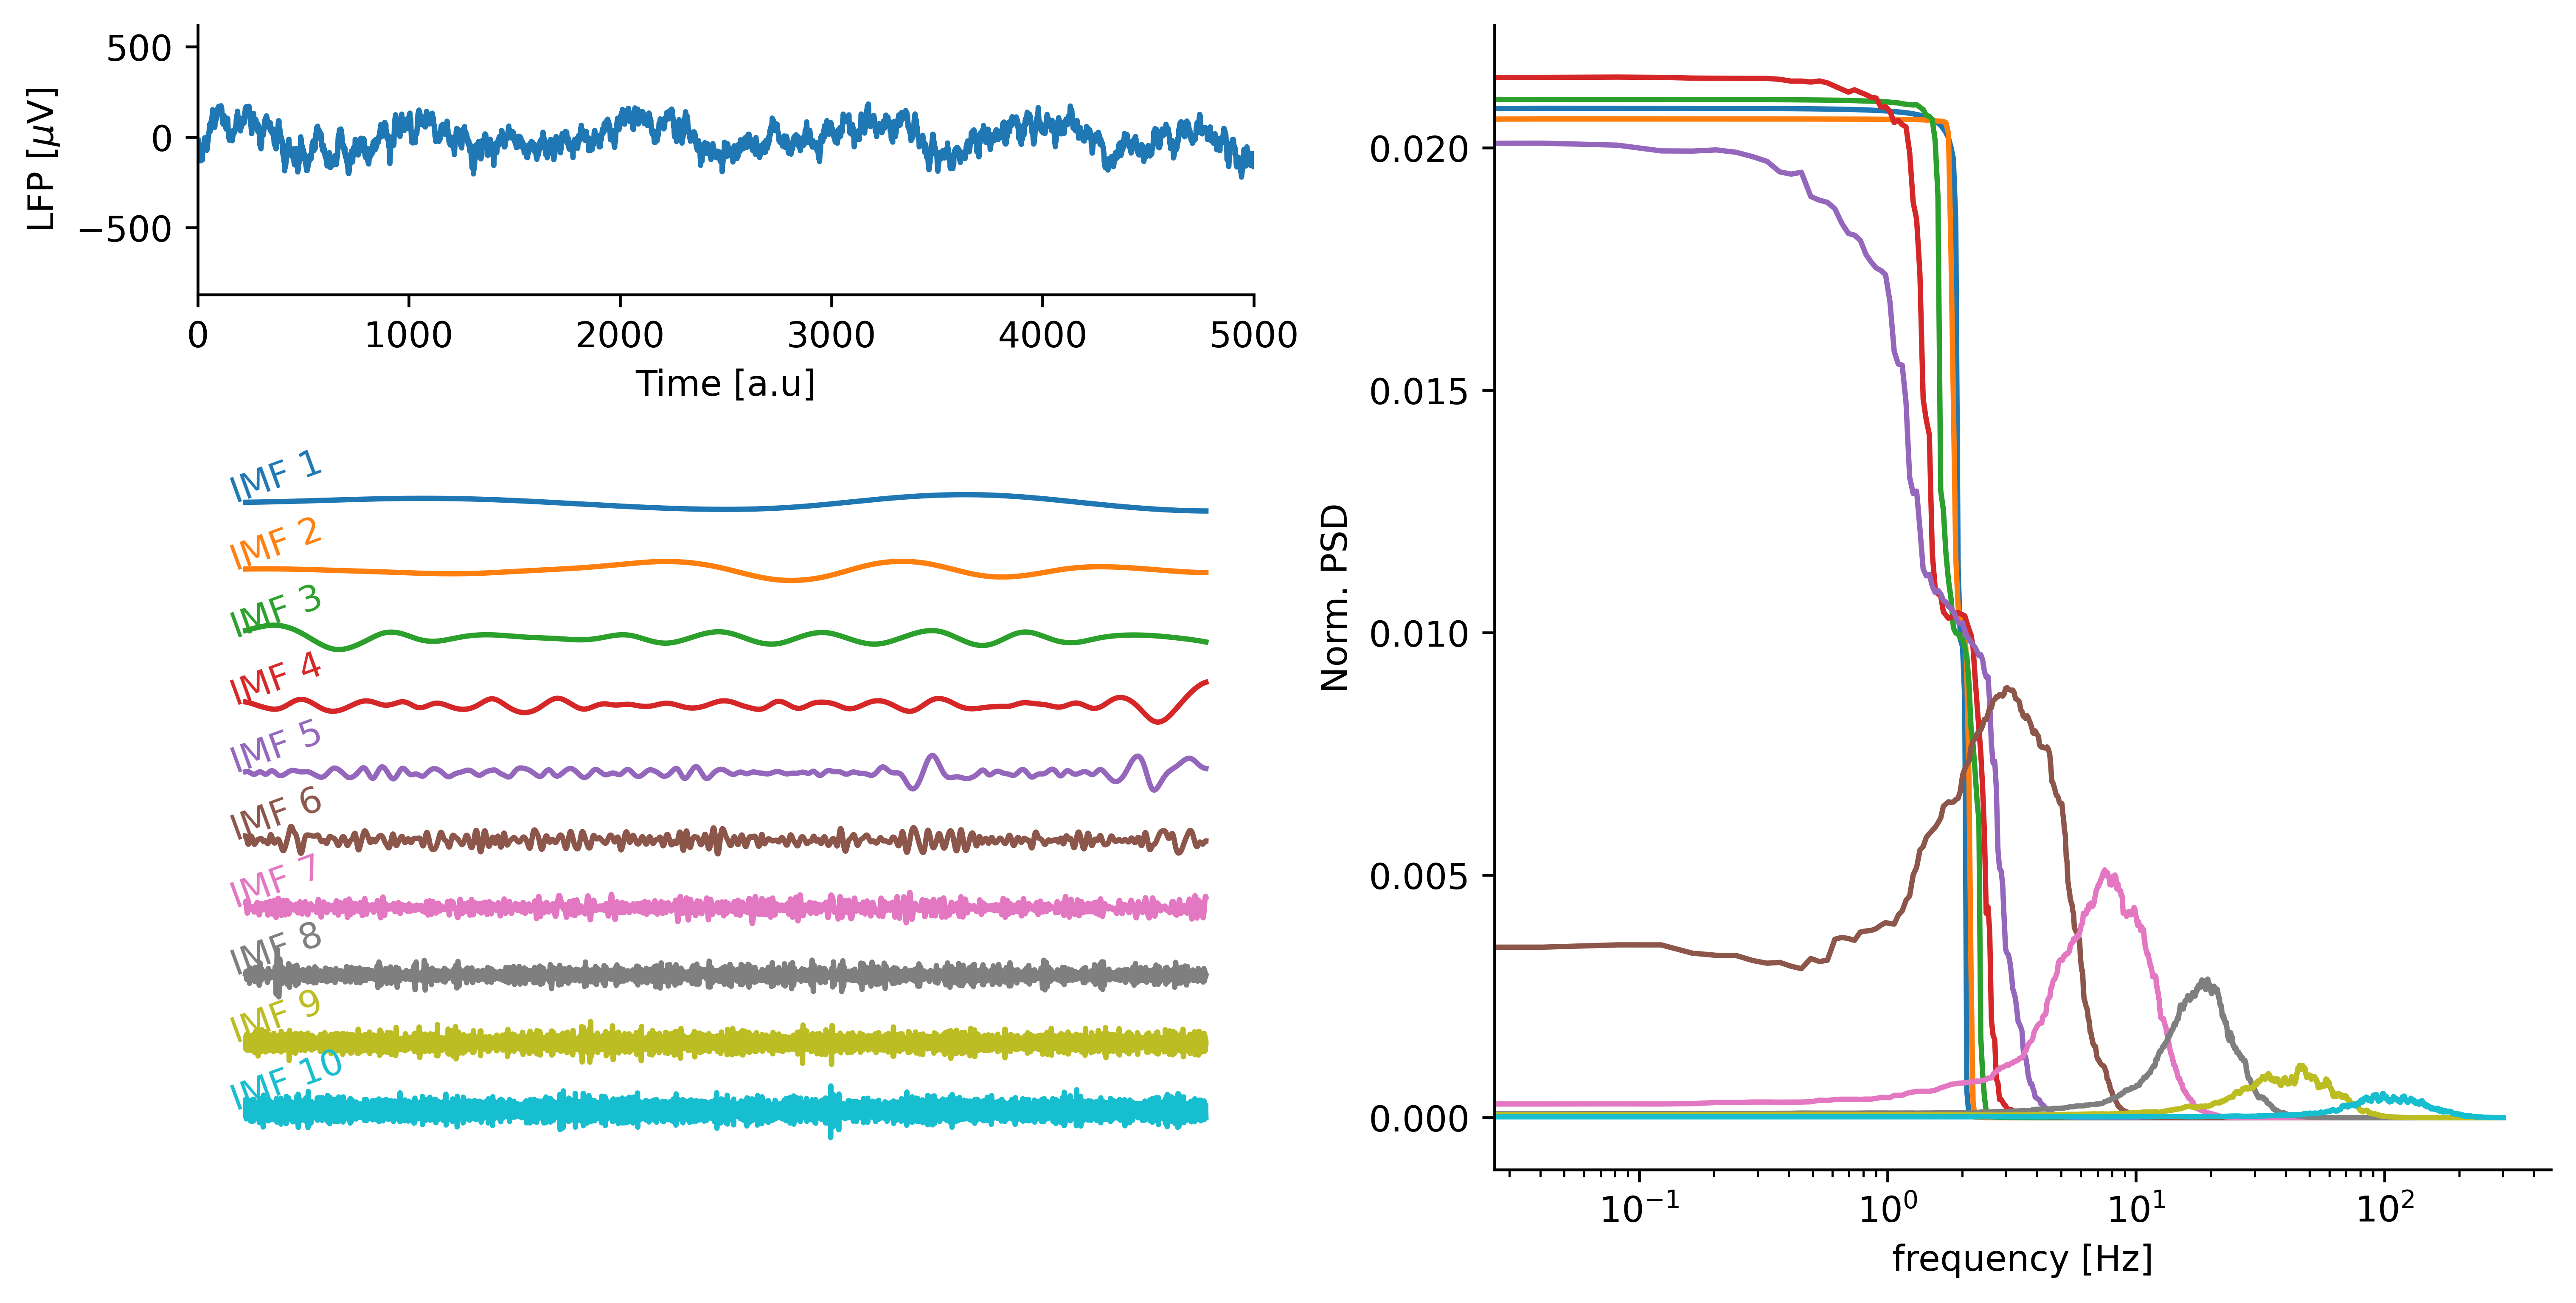

In [13]:
imf = IMFs_single[0].data

z_imf = (imf - imf.mean(1)[:, None]) / imf.std(1)[:, None]


fig, axd = plt.subplot_mosaic(
    [["A", "A", "C", "C"], ["B", "B", "C", "C"], ["B", "B", "C", "C"]],
    layout="constrained",
    figsize=(10, 5),
    dpi=600,
)

# Plot the signal snippet
plt.sca(axd["A"])
plt.plot(data.sel(channels=33).data)
plt.xlim(0, 5000)
plt.xlabel("Time [a.u]")
plt.ylabel(r"LFP [$\mu$V]")
[axd["A"].spines[key].set_visible(False) for key in ["top", "right"]]

# Plot the signal IMFs
plt.sca(axd["B"])
colors = []
for i in range(imf.shape[0]):
    p_ = plt.plot(z_imf[i] + 14.5 * (z_imf.shape[0] - i))
    colors += [p_[0].get_color()]
    plt.text(
        -490,
        14.5 * (z_imf.shape[0] - i),
        f"IMF {i + 1}",
        color=colors[-1],
        rotation=20,
    )
    plt.axis("off")


psd, f = psd_array_multitaper(
    imf,
    fmin=0,
    fmax=300,
    sfreq=1000,
    bandwidth=4,
    verbose=False,
    n_jobs=10,
)

plt.sca(axd["C"])
for i in range(len(psd)):
    plt.semilogx(f, psd[i] / psd[i].sum())
plt.xlabel("frequency [Hz]")
plt.ylabel("Norm. PSD")
[axd["C"].spines[key].set_visible(False) for key in ["top", "right"]];

#### Clustering IMFs

In [83]:
from functools import partial

import jax
import jax.numpy as jnp


def get_bc(cycles, freq, k_sd=5):
    return cycles / (k_sd * freq)


def cxmorelet(freq, cycles, sampling_freq):
    t = jnp.linspace(-1, 1, sampling_freq * 2)

    bc = get_bc(cycles, freq)
    norm = 1 / (bc * jnp.sqrt(2 * jnp.pi))
    gauss = jnp.exp(-(t**2) / (2 * bc**2))
    sine = jnp.exp(1j * 2 * jnp.pi * freq * t)

    wavelet = norm * gauss * sine
    return wavelet / jnp.sum(jnp.abs(wavelet))


@partial(jax.jit, static_argnums=3)
@partial(jax.vmap, in_axes=(None, 0, None, None))
def wavelet_transform(signal, freq, cycles, sampling_freq):
    wavelet = cxmorelet(freq, cycles, sampling_freq)
    return jax.scipy.signal.convolve(signal, wavelet, mode="same")


@partial(jax.jit, static_argnums=3)
@partial(jax.vmap, in_axes=(None, None, 0, None))
def superlet_transform_helper(signal, freqs, order, sampling_freq):
    return wavelet_transform(signal, freqs, order, sampling_freq) * jnp.sqrt(2)


def order_to_cycles(base_cycle, max_order, mode):
    if mode == "add":
        return jnp.arange(0, max_order) + base_cycle
    elif mode == "mul":
        return jnp.arange(1, max_order + 1) * base_cycle
    else:
        raise ValueError('mode should be one of "mul" or "add"')


def get_order(f, f_min: int, f_max: int, o_min: int, o_max: int):
    return o_min + jnp.round((o_max - o_min) * (f - f_min) / (f_max - f_min))


@partial(jax.vmap, in_axes=(0, None))
def get_mask(order, max_order):
    return jnp.arange(1, max_order + 1) > order


@jax.jit
def norm_geomean(X, root_pows, eps):
    X = jnp.log(X + eps).sum(axis=0)

    return jnp.exp(X / jnp.array(root_pows).reshape(-1, 1))


# @jax.jit
def adaptive_superlet_transform(
    signal,
    freqs,
    sampling_freq: int,
    base_cycle: int,
    min_order: int,
    max_order: int,
    eps=1e-12,
    mode="mul",
):
    """Computes the adaptive superlet transform of the provided signal
    Args:
        signal (jnp.ndarray): 1D array containing the signal data
        freqs (jnp.ndarray): 1D sorted array containing the frequencies to compute the wavelets at
        sampling_freq (int): Sampling frequency of the signal
        base_cycle (int): The number of cycles corresponding to order=1
        min_order (int): The minimum upper limit of orders to be used for a frequency in the adaptive superlet.
        max_order (int): The maximum upper limit of orders to be used for a frequency in the adaptive superlet.

        eps (float, optional): Epsilon value to be used for numerical stability in the geometric mean. Defaults to 1e-12.
        mode (str, optional): "add" or "mul", corresponding to the use of additive or multiplicative adaptive superlets. Defaults to "mul".
    Returns:
        jnp.ndarray: 2D array (Frequency x Time) representing the computed scalogram
    """
    cycles = order_to_cycles(base_cycle, max_order, mode)
    orders = get_order(freqs, min(freqs), max(freqs), min_order, max_order)
    mask = get_mask(orders, max_order)

    out = superlet_transform_helper(signal, freqs, cycles, sampling_freq)
    out = out.at[mask.T].set(1)

    return norm_geomean(out, orders, eps)


def superlets(
    data,
    freqs,
    sampling_freq,
    base_cycle=3,
    min_order=1,
    max_order=30,
    eps=1e-12,
    mode="mul",
):
    if not isinstance(data, jax.numpy.ndarray):
        data = jnp.array(data)
    if not isinstance(freqs, jax.numpy.ndarray):
        freqs = jnp.array(freqs)

    _fcn = partial(
        adaptive_superlet_transform,
        freqs=freqs,
        sampling_freq=sampling_freq,
        base_cycle=base_cycle,
        min_order=min_order,
        max_order=max_order,
        eps=eps,
        mode=mode,
    )

    def _loop(carry, array):
        return carry, _fcn(array)

    # tf = jax.vmap(jax.vmap(_fcn, in_axes=(0,)), in_axes=(0,))
    _, results = jax.lax.scan(_loop, None, data)

    return results

In [84]:
IMFs = IMFs_single.stack(samples=("blocks", "IMFs")).T.dropna("samples").data

In [85]:
SXX, f = psd_array_multitaper(
    IMFs,
    fmin=0,
    fmax=300,
    sfreq=1000,
    verbose=True,
    bandwidth=4,
    n_jobs=20,
)

SXX_norm = SXX / SXX.mean(1)[:, None]

    Using multitaper spectrum estimation with 100 DPSS windows


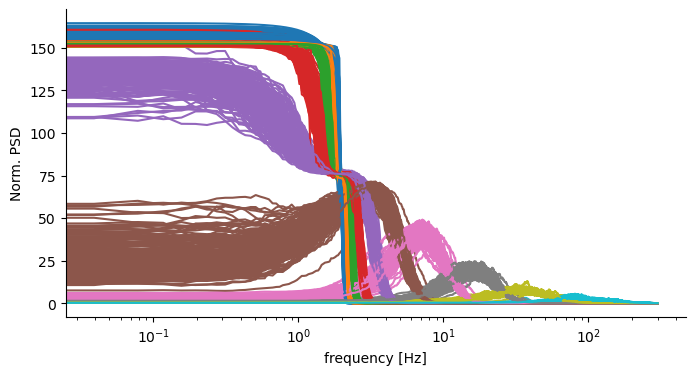

In [86]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
plt.semilogx(f, SXX_norm.T)
plt.xlabel("frequency [Hz]")
plt.ylabel("Norm. PSD")
[ax.spines[key].set_visible(False) for key in ["top", "right"]];

In [87]:
reducer = umap.UMAP(
    n_jobs=20,
    min_dist=0.5,
    n_neighbors=5,
)
embedding = reducer.fit_transform(SXX_norm)

/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [144]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans

#  clustering = KMeans(n_clusters=6, init="k-means++", n_init="auto").fit(SXX_norm)

knn = NearestNeighbors(n_neighbors=20, n_jobs=20, metric="euclidean")
knn_fit = knn.fit(SXX_norm)

distances, indices = knn_fit.kneighbors(SXX_norm)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

eps = 4 * distances[np.argmax(curvature(distances))]

clustering = DBSCAN(eps=eps, min_samples=20).fit(SXX_norm)

In [145]:
clustering.labels_

array([0, 0, 0, ..., 3, 4, 4])

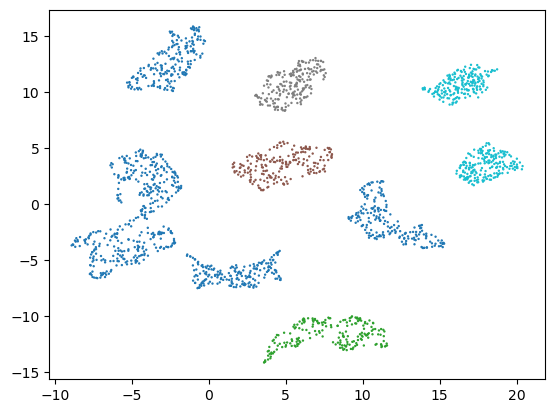

In [146]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.5, c=clustering.labels_, cmap="tab10")

In [147]:
labels = clustering.labels_.copy()

In [148]:
from sklearn.metrics import pairwise_distances_argmin_min

if -1 in np.unique(labels):

    labels = clustering.labels_.copy()

    # Identify noise points
    noise_points = SXX_norm[labels == -1]

    # Find the closest cluster for each noise point
    closest_cluster_indices = pairwise_distances_argmin_min(
        noise_points, SXX_norm[labels != -1]
    )[0]
    closest_cluster_labels = labels[closest_cluster_indices]

    # Assign noise points to the closest cluster
    labels[labels == -1] = closest_cluster_labels

    clustering.labels_ = labels

In [149]:
unique_labels = np.unique(clustering.labels_)
n_cluster = len(unique_labels)

In [150]:
def average_for_cluster(data=None, cluster_labels=None, label=None):
    return data[cluster_labels == label].mean(0)


partial_average_for_cluster = partial(
    average_for_cluster, data=SXX_norm, cluster_labels=clustering.labels_
)

out = np.stack([partial_average_for_cluster(label=label) for label in unique_labels])

order = np.argsort(out.argmax(axis=1))

In [151]:
unique_labels[order]

array([0, 1, 2, 3, 4])

In [152]:
cluster_labels = clustering.labels_.reshape(-1, IMFs_single.shape[1])

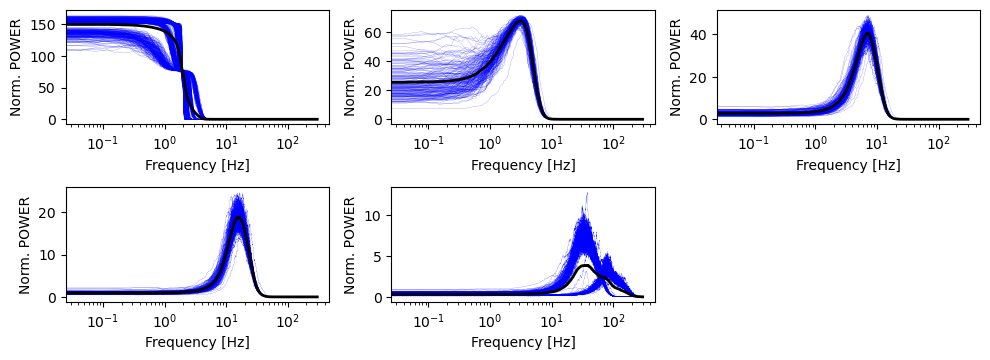

In [153]:
plt.figure(figsize=(10, 5))
for pos, i in enumerate(unique_labels[order]):
    plt.subplot(3, 3, pos + 1)
    plt.semilogx(f, SXX_norm[clustering.labels_ == i].T, lw=0.1, color="b")
    plt.semilogx(f, SXX_norm[clustering.labels_ == i].mean(0), lw=2, color="k")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Norm. POWER")
plt.tight_layout()

#### Computing composite signals

In [31]:
n_blocks = IMFs_single.shape[0]

In [ ]:
composite = []

for i in range(n_blocks):
    labels = cluster_labels[i]
    composite += [
        IMFs_single[i]
        .dropna("IMFs")
        .assign_coords({"IMFs": labels})
        .groupby("IMFs")
        .sum("IMFs")
    ]

composite = xr.concat(composite, "blocks")

In [ ]:
SXX_composite, f = psd_array_multitaper(
    composite,
    fmin=0,
    fmax=300,
    sfreq=1000,
    verbose=True,
    bandwidth=4,
    n_jobs=20,
)

In [ ]:
plt.figure(figsize=(10, 5))
for pos, i in enumerate(unique_labels[order]):
    plt.subplot(3, 3, pos + 1)
    plt.semilogx(f, SXX_composite[:, i, :].T, c="b", lw=0.1)
    plt.semilogx(f, np.nanmean(SXX_composite[:, i, :], 0), c="r", lw=3)
plt.tight_layout()

In [ ]:
block = 179

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
composite.isel(IMFs=0, blocks=block).plot(hue="IMFs")
plt.subplot(4, 1, 2)
composite.isel(IMFs=1, blocks=block).plot(hue="IMFs")
plt.subplot(4, 1, 3)
composite.isel(IMFs=2, blocks=block).plot(hue="IMFs")
plt.tight_layout()

#### Checking all channels

In [170]:
date = "10-13-2022"
monkey = "FN"
max_imfs = None
method = "eemd"


IMFpath = os.path.expanduser(
    f"~/funcog/HoffmanData/{monkey}/{date}/IMFs_task_method_{method}_max_imfs_{max_imfs}.nc"
)

In [171]:
# Path in which to save figures
figures_path = f"figures/{monkey}/{date}"

if not os.path.isdir(figures_path):
    os.makedirs(figures_path)

In [172]:
IMFs_dataset = xr.open_dataset(IMFpath)

In [173]:
channels = list(IMFs_dataset.keys())

In [174]:
f_mt = partial(
    psd_array_multitaper,
    fmin=0,
    fmax=300,
    sfreq=1000,
    verbose=True,
    bandwidth=4,
    n_jobs=20,
)

In [248]:
def reassign_noise_points(data, labels):
    """
    Reassigns noise points in the clustering labels to the closest cluster.

    Parameters:
    - data (numpy.ndarray): Input data points.
    - labels (numpy.ndarray): Cluster labels assigned to each data point.

    Returns:
    - numpy.ndarray: Updated cluster labels with noise points reassigned to the closest cluster.

    If there are noise points represented by the label -1 in the input labels, this function
    identifies those points, finds the closest cluster for each noise point, and reassigns
    them to the cluster with the most occurrences among the closest clusters.
    """
    # Set noise points to the closest cluster
    if -1 in np.unique(labels):

        # Identify noise points
        noise_points = data[labels == -1]

        # Find the closest cluster for each noise point
        closest_cluster_indices = pairwise_distances_argmin_min(
            noise_points, data[labels != -1]
        )[0]
        closest_cluster_labels = labels[closest_cluster_indices]

        # Assign noise points to the closest cluster
        labels[labels == -1] = closest_cluster_labels

        return labels

    return labels


def curvature(x):

    div = np.gradient(x)
    lap = np.gradient(x)

    K = np.abs(lap) / ((1 + div**2) ** 1.5)

    return K

In [250]:
reducer = umap.UMAP(
    n_jobs=20,
    min_dist=0.5,
    n_neighbors=20,
)

for channel in channels[8:]:
    #################################################################
    # Get IMFs for channel
    #################################################################
    IMFs_single = IMFs_dataset[channel].load().dropna("IMFs")

    IMFs = IMFs_single.stack(samples=("blocks", "IMFs")).T
    #################################################################
    # Compute power-spectrum for IMFs
    #################################################################
    SXX, f = f_mt(IMFs)

    SXX_norm = SXX / SXX.mean(1)[:, None]

    #################################################################
    # Embed power-spectra
    #################################################################

    embedding = reducer.fit_transform(SXX_norm)

    knn = NearestNeighbors(n_neighbors=20, n_jobs=20, metric="euclidean")
    knn_fit = knn.fit(SXX_norm)

    distances, indices = knn_fit.kneighbors(SXX_norm)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    eps = distances[np.argmax(distances)]
    # Cluster power-spectra
    clustering = DBSCAN(eps=eps, min_samples=20).fit(SXX_norm)
    clustering.labels_ = reassign_noise_points(SXX_norm, clustering.labels_)
    unique_labels = np.unique(clustering.labels_)
    n_cluster = len(unique_labels)

    #################################################################
    # Order labels by power peak
    #################################################################
    partial_average_for_cluster = partial(
        average_for_cluster, data=SXX_norm, cluster_labels=clustering.labels_
    )

    out = np.stack(
        [partial_average_for_cluster(label=label) for label in unique_labels]
    )

    order = np.argsort(out.argmax(axis=1))

    #################################################################
    # Plot embedding colored by cluster labels
    #################################################################
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    plt.scatter(
        embedding[:, 0], embedding[:, 1], s=0.5, c=clustering.labels_, cmap="tab10"
    )
    plt.title(f"embedding IMFs - monkey {monkey} - date {date} - {channel}")
    plt.axis("off")
    plt.savefig(os.path.join(figures_path, f"embedding_imfs_{channel}.png"))
    plt.close()

    #################################################################
    # Plot spectra for each cluster
    #################################################################
    plt.figure(figsize=(10, 5))
    for pos, i in enumerate(unique_labels[order]):
        ax = plt.subplot(3, 3, pos + 1)
        plt.semilogx(f, SXX_norm[clustering.labels_ == i].T, lw=0.1, color="b")
        plt.semilogx(f, SXX_norm[clustering.labels_ == i].mean(0), lw=2, color="k")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Norm. POWER")
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, f"clustered_imf_spectra_{channel}.png"))
    plt.close()

    #################################################################
    # Generate composite signals
    #################################################################
    n_blocks = IMFs_single.shape[0]
    cluster_labels = clustering.labels_.reshape(-1, IMFs_single.shape[1])

    composite = []

    for i in range(n_blocks):
        labels = cluster_labels[i]
        composite += [
            IMFs_single[i]
            .dropna("IMFs")
            .assign_coords({"IMFs": labels})
            .groupby("IMFs")
            .sum("IMFs")
        ]

    composite = xr.concat(composite, "blocks")

    #################################################################
    # Compute power-spectrum for composite signals
    #################################################################
    SXX_composite, f = f_mt(composite)

    plt.figure(figsize=(10, 5))
    for pos, i in enumerate(unique_labels[order]):
        ax = plt.subplot(3, 3, pos + 1)
        plt.semilogx(f, SXX_composite[:, i, :].T, c="b", lw=0.1)
        plt.semilogx(f, np.nanmean(SXX_composite[:, i, :], 0), c="r", lw=3)
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Norm. POWER")
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.tight_layout()
    plt.savefig(
        os.path.join(figures_path, f"clustered_composites_spectra_{channel}.png")
    )
    plt.close()

    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
    Using multitaper spectrum estimation with 130 DPSS windows


/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    Using multitaper spectrum estimation with 130 DPSS windows
